In [1]:
import os
import time

import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec

%matplotlib inline

print("Package is ready.")

Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 14})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

In [3]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [4]:
N_FOLD = 5
TIME_STEP = 144
OUTPUT_SIZE = 12

# Figure 1

### greenhouse environment

In [5]:
raw_df = pd.read_csv("../../data/BR_env/forced_env.csv", index_col=["Unnamed: 0"])
raw_df = pd.DataFrame(raw_df, dtype="float")

In [6]:
INTERVAL = '7d'
START_DATE = '2016-10-02 00:00'
END_DATE = raw_df.index[-1]

In [7]:
weather_df = raw_df[[col for col in raw_df.columns if '.w' in col]]
soil_df = raw_df[[col for col in raw_df.columns if 's_' in col]]
greenhouse_df = raw_df.drop([col for col in raw_df.columns if '.w' in col], axis=1)
greenhouse_df = greenhouse_df.drop([col for col in raw_df.columns if 's_' in col], axis=1)

In [8]:
new_coloumns = []
for col in greenhouse_df.columns:
    new_coloumns.append(col.split(".")[0])
greenhouse_df.columns = new_coloumns

new_coloumns = []
for col in soil_df.columns:
    new_coloumns.append(col.split(".")[0])
soil_df.columns = new_coloumns

In [9]:
greenhouse_df = greenhouse_df.groupby(greenhouse_df.columns, axis=1, sort=False).mean()
soil_df = soil_df.groupby(soil_df.columns, axis=1, sort=False).mean()

env_df = pd.concat([greenhouse_df, soil_df, weather_df], axis=1)

In [10]:
env_df.index = pd.DatetimeIndex(env_df.index)
env_df.index = pd.DatetimeIndex(env_df.index.date)

In [11]:
_ = env_df.index.round(INTERVAL).tolist()
for i in range(500):
    if _[i] < pd.Timestamp('2016-10-02 00:00:00'):
        _[i] = pd.Timestamp('2016-10-02 00:00:00')
env_df.index = _

In [12]:
_ = env_df[~(env_df["rad"] < 1)]["rad"]
_ = _.dropna()
_ = _.groupby(_.index).mean()

In [13]:
env_df = env_df.groupby(env_df.index).mean()
env_df["rad"] = _/54

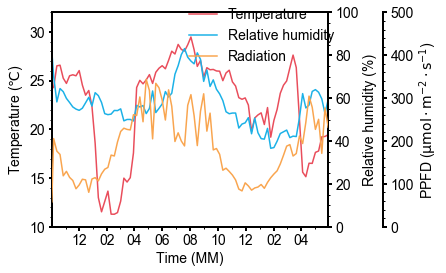

In [14]:
x_date = env_df.index

fig = plt.figure(figsize=((8.5/2.54)*2, (6/2.54)*1.7))
ax0 = plt.subplot()
line_temp, = ax0.plot(x_date, env_df["temp"], c=cmap[0], label = "Temperature")

ax0.set_ylabel("Temperature ($℃$)")
ax0.set_ybound([10, 32])
ax0.yaxis.set_major_locator(MultipleLocator(5))
ax0.yaxis.set_minor_locator(MultipleLocator(1))

hum = ax0.twinx()
line_hum, = hum.plot(x_date, env_df[["rh"]], c=cmap[4], label = "Relative humidity")

hum.set_ylabel("Relative humidity (%)")
hum.set_ybound([0, 100])
hum.yaxis.set_major_locator(MultipleLocator(20))
hum.yaxis.set_minor_locator(MultipleLocator(5))

rad = ax0.twinx()
line_rad, = rad.plot(x_date, env_df[["rad"]], c=cmap[2], label = "Radiation")
rad.set_ylabel("PPFD ($\mu mol\cdot m^{-2}\cdot s^{-1}$)")
rad.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(rad)
rad.spines["right"].set_visible(True)

fig.legend(handles=[line_temp, line_hum, line_rad], 
           labels = ["Temperature", "Relative humidity", "Radiation"],
           frameon=False, bbox_to_anchor=(0.72, 0.96))
plt.axis([x_date[0],x_date[-1], 0, 500])

ax0.set_xlabel("Time (MM)")

rad.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
rad.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
rad.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
rad.yaxis.set_major_locator(MultipleLocator(100))
rad.yaxis.set_minor_locator(MultipleLocator(20))

fig.tight_layout()

fig.savefig("./figures/Fig1.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 5&6

### 1:1 & regerssion line (training)

In [15]:
train_results = []
train_labels = []
for i in range(5):
    train_result = pd.read_csv("./results/train_rsCO2_LSTM_bestloss_T144_I10 min_F"+str(i+1)+".CSV", index_col=["Unnamed: 0"])
    train_label = pd.read_csv("./results/train_lbCO2_LSTM_bestloss_T144_I10 min_F"+str(i+1)+".CSV", index_col=["Unnamed: 0"])
#     train_result.index = pd.DatetimeIndex(train_result.index)
#     train_label.index = pd.DatetimeIndex(train_label.index)
    train_results.append(train_result)
    train_labels.append(train_label)
train_result = pd.concat(train_results)
train_label = pd.concat(train_labels)
# train_result = train_result[~train_result.index.duplicated()]
# train_label = train_label[~train_label.index.duplicated()]

In [16]:
for i in range(5):

    r2_train = r2_score(train_labels[i].values.reshape(-1, 1), train_results[i].values.reshape(-1, 1))
    rmse_train = np.sqrt(mean_squared_error(train_labels[i].values.reshape(-1, 1), train_results[i].values.reshape(-1, 1)))

    print(r2_train)
    print(rmse_train)
    print()

0.7454766575673671
53.34391201506713

0.8448217765554502
55.94905159159546

0.8682573695883204
48.46601640129475

0.8661514670169843
51.54118492120854

0.7877751983186237
65.5805265672518



In [17]:
r2_train = r2_score(train_label.values.reshape(-1, 1), train_result.values.reshape(-1, 1))
rmse_train = np.sqrt(mean_squared_error(train_label.values.reshape(-1, 1), train_result.values.reshape(-1, 1)))

print(r2_train)
print(rmse_train)

0.830956118291025
55.28534602660714


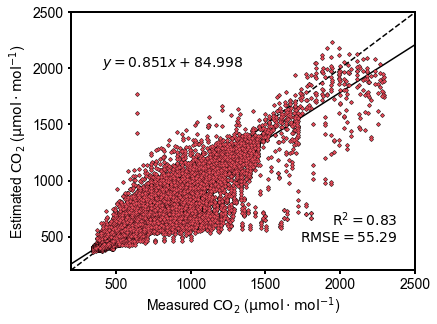

In [18]:
min_ = min(train_result.min())
max_ = max(train_result.max())
x_ = np.arange(min(train_result.min()) - 1500, max(train_result.max()) + 1500).reshape(-1,1)

X, Y = train_label.mean(axis=1).values.reshape(-1, 1), train_result.mean(axis=1).values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(X, Y)
Yp = regr.predict(X)
reg_x = x_
reg_y = reg_x*regr.coef_ + regr.intercept_

fig = plt.figure(figsize = ((8/2.54)*2, (6/2.54)*2))
ax = plt.subplot()
x_linear = x_
y_linear = x_linear

reg_line = ax.plot(reg_x, reg_y, "k-", label = "regression line", zorder=7)
linear = ax.plot(x_linear, y_linear, "k--", label = "1:1 line", zorder=5)
for i in range(5):
    scatter = ax.scatter(train_label.mean(axis=1), train_result.mean(axis=1), edgecolor='black', linewidth=0.25, 
                         s=MARKER_SIZE/1.5, c=cmap[0], label = "$CO_2$ concentration", zorder=10)
if regr.intercept_ < 0:
    ax.text(0.5, 0.77, '$\it{y = %.3fx%.3f}$' % (regr.coef_, regr.intercept_),
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
else:
    ax.text(0.5, 0.77, '$\it{y = %.3fx+%.3f}$' % (regr.coef_, regr.intercept_),
    verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
ax.text(0.95, 0.1, '$R^{2} = %.2f$\n$RMSE = %.2f$' % (r2_train, rmse_train),
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
#ax.legend(handles = [scatter], frameon = False)
plt.xlabel("Measured $CO_2$ ($\mu mol \cdot mol^{-1}$)")
plt.ylabel("Estimated $CO_2$ ($\mu mol \cdot mol^{-1}$)")
plt.axis([200, 2500, 200, 2500])
fig.tight_layout()
fig.savefig("./figures/Fig5a.png", dpi=600, transparent=True, format="png")
plt.show()

### 1:1 & regerssion line (test)

In [19]:
pred_results = []
pred_labels = []
for i in range(5):
    pred_result = pd.read_csv("./results/output_CO2_LSTM_bestloss_T144_I10 min_F"+str(i+1)+".CSV", index_col="Unnamed: 0")
    pred_label = pd.read_csv("./results/labels_CO2_LSTM_bestloss_T144_I10 min_F"+str(i+1)+".CSV", index_col=["Unnamed: 0"])
    pred_result.index = pd.DatetimeIndex(pred_result.index)
    pred_label.index = pd.DatetimeIndex(pred_label.index)
    pred_results.append(pred_result)
    pred_labels.append(pred_label)
pred_result = pd.concat(pred_results)
pred_label = pd.concat(pred_labels)
pred_result = pred_result[~pred_result.index.duplicated()]
pred_label = pred_label[~pred_label.index.duplicated()]

In [20]:
r2_test = r2_score(pred_label.values.reshape(-1, 1), pred_result.values.reshape(-1, 1))
rmse_test = np.sqrt(mean_squared_error(pred_label.values.reshape(-1, 1), pred_result.values.reshape(-1, 1)))

print(r2_test)
print(rmse_test)

0.8056240483991672
57.732892817152454


In [52]:
pred_results[pd.da]

TypeError: list indices must be integers or slices, not datetime.date

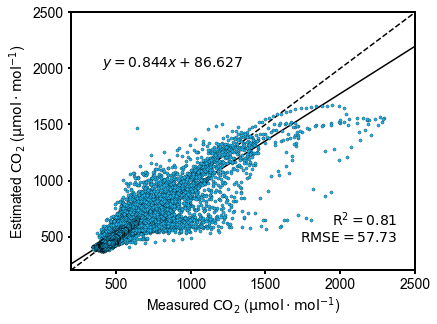

In [21]:
min_ = min(pred_result.min())
max_ = max(pred_result.max())
x_ = np.arange(min(pred_result.min()) - 1500, max(pred_result.max()) + 1500).reshape(-1,1)

X, Y = pred_label.mean(axis=1).values.reshape(-1, 1), pred_result.mean(axis=1).values.reshape(-1, 1)
regr = linear_model.LinearRegression()
regr.fit(X, Y)
Yp = regr.predict(X)
reg_x = x_
reg_y = reg_x*regr.coef_ + regr.intercept_

fig = plt.figure(figsize = ((8/2.54)*2, (6/2.54)*2))
ax = plt.subplot()
x_linear = x_
y_linear = x_linear

reg_line = ax.plot(reg_x, reg_y, "k-", label = "regression line", zorder=7)
linear = ax.plot(x_linear, y_linear, "k--", label = "1:1 line", zorder=5)
scatter = ax.scatter(pred_label.mean(axis=1), pred_result.mean(axis=1), edgecolor='black', linewidth=0.25, 
                     s=MARKER_SIZE/1.5, c=cmap[4], label = "$CO_2$ concentration", zorder=10)
if regr.intercept_ < 0:
    ax.text(0.5, 0.77, '$\it{y = %.3fx%.3f}$' % (regr.coef_, regr.intercept_),
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
else:
    ax.text(0.5, 0.77, '$\it{y = %.3fx+%.3f}$' % (regr.coef_, regr.intercept_),
    verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
ax.text(0.95, 0.1, '$R^{2} = %.2f$\n$RMSE = %.2f$' % (r2_test, rmse_test),
            verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
#ax.legend(handles = [scatter], frameon = False)
plt.xlabel("Measured $CO_2$ ($\mu mol \cdot mol^{-1}$)")
plt.ylabel("Estimated $CO_2$ ($\mu mol \cdot mol^{-1}$)")
plt.axis([200, 2500, 200, 2500])
fig.tight_layout()
fig.savefig("./figures/Fig5b.png", dpi=600, transparent=True, format="png")
plt.show()

In [32]:
(pred_label.mean(axis=1) - pred_result.mean(axis=1)).sort_values()

2017-01-28 10:10:00    -827.238160
2017-01-03 11:10:00    -492.275994
2017-01-03 11:20:00    -466.581240
2017-05-10 09:40:00    -461.092365
2017-10-05 09:10:00    -458.253288
2017-10-09 09:10:00    -449.951012
2017-10-05 09:00:00    -445.949304
2017-01-03 11:00:00    -431.678285
2017-01-08 10:50:00    -418.414794
2017-01-06 10:40:00    -416.708672
2017-01-08 11:00:00    -409.723708
2017-01-08 10:40:00    -390.006248
2017-10-08 09:00:00    -387.971514
2017-01-09 10:50:00    -387.005503
2017-01-23 10:50:00    -386.258152
2017-10-09 09:00:00    -384.577945
2017-05-10 09:20:00    -381.367836
2017-01-09 11:00:00    -381.005800
2017-05-10 09:30:00    -380.624093
2017-01-26 10:00:00    -380.542990
2017-01-28 10:20:00    -379.379686
2017-01-23 10:40:00    -375.396818
2017-02-01 10:20:00    -374.120568
2017-06-01 10:30:00    -369.151970
2017-01-05 13:30:00    -366.613915
2017-10-08 09:10:00    -366.349608
2017-01-09 10:40:00    -365.218013
2017-01-03 10:50:00    -358.831090
2017-10-08 08:50:00 

In [33]:
INTERVAL = pd.Timedelta("10 min")
pred_result.index = pd.DatetimeIndex(pred_result.index)
pred_label.index = pd.DatetimeIndex(pred_label.index)

In [34]:
COLUMNS = []
for i in range(pred_result.shape[1]):
    COLUMNS.append(INTERVAL*i)
pred_result.columns = COLUMNS
pred_label.columns = COLUMNS

In [35]:
predictions = []
pred_labels = []
for i in range(pred_result.shape[1]):
    temp = pred_result.iloc[:, i].copy()
    temp.index += INTERVAL*i
    temp = pd.DataFrame(temp)
    temp.columns = ["CO2"]
    predictions.append(temp)
    
    temp = pred_label.iloc[:, i].copy()
    temp.index += INTERVAL*i
    temp = pd.DataFrame(temp)
    temp.columns = ["CO2"]
    pred_labels.append(temp)
    
    if i % 10000 == 0:
        print("%d processed..." % i)

0 processed...


In [36]:
predictions = pd.concat(predictions, axis=1)
pred_label = pd.concat(pred_labels, axis=1)

In [37]:
predictions

,CO2,CO2,CO2,CO2,CO2,CO2,CO2,CO2,CO2,CO2,CO2,CO2
2016-10-03 00:00:00,680.041505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-03 00:10:00,685.711999,684.771522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-03 00:20:00,691.073505,690.979451,691.312254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-03 00:30:00,689.904514,696.700317,698.048587,693.731179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-03 00:40:00,685.474388,695.366897,704.173198,700.789545,699.262297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-03 00:50:00,683.561524,688.894499,702.779874,707.193075,706.665206,700.614414,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-03 01:00:00,691.910898,688.664514,694.931845,705.785536,713.421340,708.310858,705.302052,NaN,NaN,NaN,NaN,NaN
2016-10-03 01:10:00,696.675030,697.983398,695.694048,697.373515,712.150970,715.393173,713.178612,704.619087,NaN,NaN,NaN,NaN
2016-10-03 01:20:00,692.185903,702.514200,705.700914,698.646528,703.170775,714.327802,720.567974,712.427882,704.425091,NaN,NaN,NaN
2016-10-03 01:30:00,685.308488,697.205374,710.169304,708.916025,704.460914,705.449890,719.804668,720.005220,711.781575,702.158352,NaN,NaN


In [38]:
label_means = pred_label.mean(axis=1)

In [39]:
pred_means = predictions.mean(axis=1, skipna=True)
pred_maxs = predictions.max(axis=1, skipna=True)
pred_mins = predictions.min(axis=1, skipna=True)

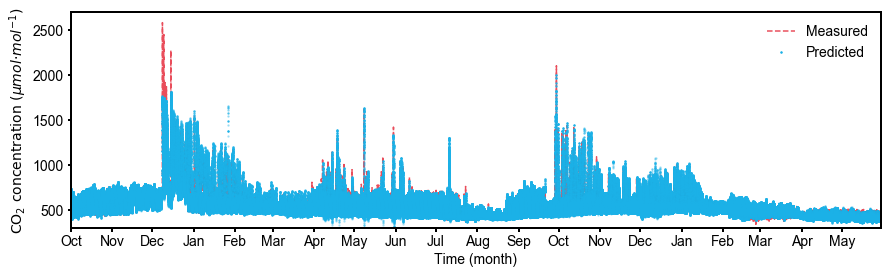

In [40]:
x_date = predictions.index
#LL = 9000

fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*1.7))
ax = plt.subplot()
#plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)

linear_label = ax.plot(x_date, label_means, "--", markersize=MARKER_SIZE / 2, c=cmap[0])
for j in range(0, predictions.shape[1]-1):
    ax.plot(x_date, predictions.iloc[:,j], "o", markersize=MARKER_SIZE/10, c=cmap[4], alpha=1/(j/3+1))
#linear_sq1 = plt.plot(x_date, pred_squences.iloc[:,0], "-", c=cmap[3], alpha=1)
#linear_sq12 = plt.plot(x_date, pred_squences.iloc[:,11], "-", c=cmap[-1], alpha=1)


plt.legend(["Measured", "Predicted"], bbox_to_anchor=(1, 1), frameon=False)

months = MonthLocator(range(1, 13), bymonthday=3, interval=1)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# mondays = WeekdayLocator(MONDAY)
# ax.xaxis.set_minor_locator(mondays)


plt.xlabel("Time (month)")
plt.ylabel("$CO_2\ concentration\ \mathit{({\mu}mol{\cdot}mol^{-1})}$")
ax.axis([x_date[0], x_date[-1], 300, 2700])
fig.tight_layout()
fig.savefig("./figures/Fig6.png", dpi=600, transparent=True, format="png")
plt.show()

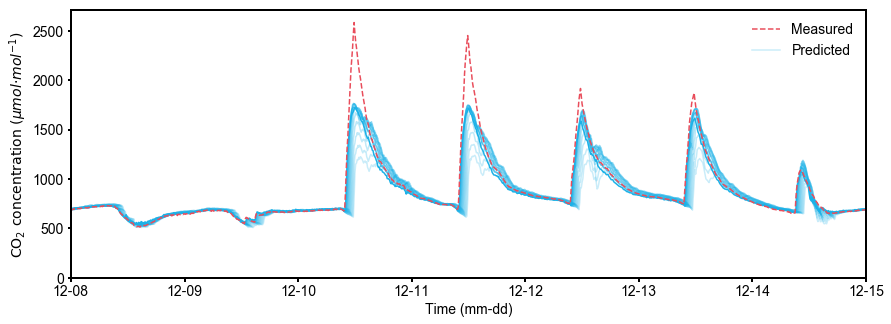

In [45]:
x_date = predictions.index
#LL = 9000

fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
ax = plt.subplot()
#plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)


for j in range(0, predictions.shape[1]-1):
    a, = ax.plot(x_date, predictions.iloc[:,j], "-", markersize=MARKER_SIZE/10, c=cmap[4], alpha=1/(j/3+1))
#linear_sq1 = plt.plot(x_date, pred_squences.iloc[:,0], "-", c=cmap[3], alpha=1)
#linear_sq12 = plt.plot(x_date, pred_squences.iloc[:,11], "-", c=cmap[-1], alpha=1)
linear_label, = ax.plot(x_date, label_means, "--", markersize=MARKER_SIZE / 2, c=cmap[0])

plt.legend(handles = [linear_label, a], labels = ["Measured", "Predicted"], bbox_to_anchor=(1, 1), frameon=False)

#months = MonthLocator(range(1, 13), bymonthday=3, interval=1)
#ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# mondays = WeekdayLocator(MONDAY)
# ax.xaxis.set_minor_locator(mondays)


plt.xlabel("Time (mm-dd)")
plt.ylabel("$CO_2\ concentration\ \mathit{({\mu}mol{\cdot}mol^{-1})}$")
ax.set_xbound([datetime.date(2016, 12, 8), datetime.date(2016, 12, 15)])
#ax.set_ybound([300, 1400])
fig.tight_layout()
fig.savefig("./figures/Fig6a.png", dpi=600, transparent=True, format="png")
plt.show()

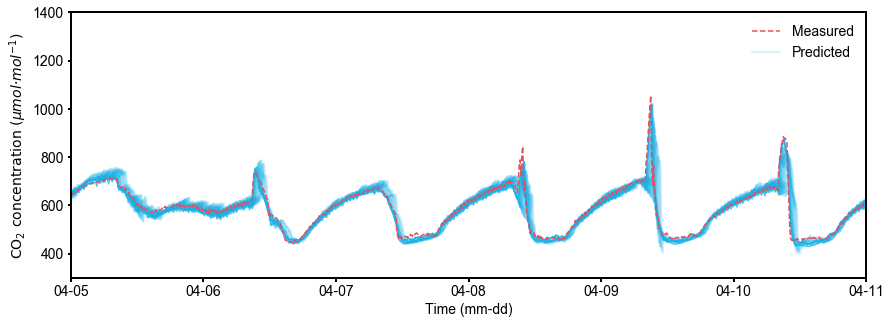

In [35]:
x_date = predictions.index
#LL = 9000

fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*2))
ax = plt.subplot()
#plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)


for j in range(0, predictions.shape[1]-1):
    a, = ax.plot(x_date, predictions.iloc[:,j], "-", markersize=MARKER_SIZE/10, c=cmap[4], alpha=1/(j/3+1))
#linear_sq1 = plt.plot(x_date, pred_squences.iloc[:,0], "-", c=cmap[3], alpha=1)
#linear_sq12 = plt.plot(x_date, pred_squences.iloc[:,11], "-", c=cmap[-1], alpha=1)
linear_label, = ax.plot(x_date, label_means, "--", markersize=MARKER_SIZE / 2, c=cmap[0])

plt.legend(handles = [linear_label, a], labels = ["Measured", "Predicted"], bbox_to_anchor=(1, 1), frameon=False)

#months = MonthLocator(range(1, 13), bymonthday=3, interval=1)
#ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# mondays = WeekdayLocator(MONDAY)
# ax.xaxis.set_minor_locator(mondays)


plt.xlabel("Time (mm-dd)")
plt.ylabel("$CO_2\ concentration\ \mathit{({\mu}mol{\cdot}mol^{-1})}$")
ax.set_xbound([datetime.date(2017, 4, 5), datetime.date(2017, 4, 11)])
ax.set_ybound([300, 1400])
fig.tight_layout()
fig.savefig("./figures/Fig6a.png", dpi=600, transparent=True, format="png")
plt.show()

In [76]:
np.sqrt(mean_squared_error(pred_label.loc[datetime.date(2017,4,1):datetime.date(2017,4,30)].values.reshape(-1, 1),
                           pred_result.loc[datetime.date(2017,4,1):datetime.date(2017,4,30)].values.reshape(-1, 1)))

45.12631634727987

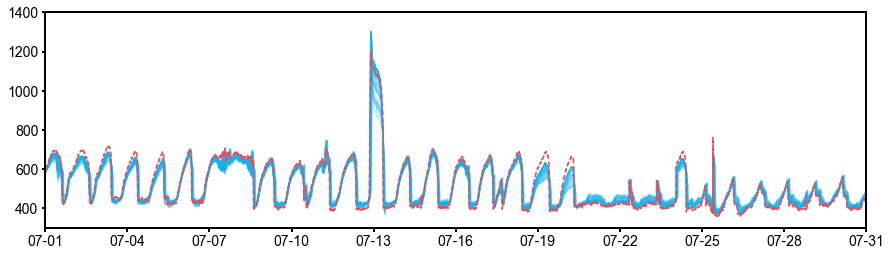

In [68]:
x_date = predictions.index
#LL = 9000

fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*1.6))
ax = plt.subplot()
#plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)


for j in range(0, predictions.shape[1]-1):
    a, = ax.plot(x_date, predictions.iloc[:,j], "-", markersize=MARKER_SIZE/10, c=cmap[4], alpha=1/(j/3+1))
#linear_sq1 = plt.plot(x_date, pred_squences.iloc[:,0], "-", c=cmap[3], alpha=1)
#linear_sq12 = plt.plot(x_date, pred_squences.iloc[:,11], "-", c=cmap[-1], alpha=1)
linear_label, = ax.plot(x_date, label_means, "--", markersize=MARKER_SIZE / 2, c=cmap[0])

#plt.legend(handles = [linear_label, a], labels = ["Measured", "Predicted"], bbox_to_anchor=(1, 1), frameon=False)

#months = MonthLocator(range(1, 13), bymonthday=3, interval=1)
#ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# mondays = WeekdayLocator(MONDAY)
# ax.xaxis.set_minor_locator(mondays)


#plt.xlabel("Time (mm-dd)")
#plt.ylabel("$CO_2\ concentration\ \mathit{({\mu}mol{\cdot}mol^{-1})}$")
ax.set_xbound([datetime.date(2017, 7, 1), datetime.date(2017, 7, 31)])
ax.set_ybound([300, 1400])
fig.tight_layout()
fig.savefig("./figures/Fig6b.png", dpi=600, transparent=True, format="png")
plt.show()

In [77]:
np.sqrt(mean_squared_error(pred_label.loc[datetime.date(2017,7,1):datetime.date(2017,7,31)].values.reshape(-1, 1),
                           pred_result.loc[datetime.date(2017,7,1):datetime.date(2017,7,31)].values.reshape(-1, 1)))

37.02920137881246

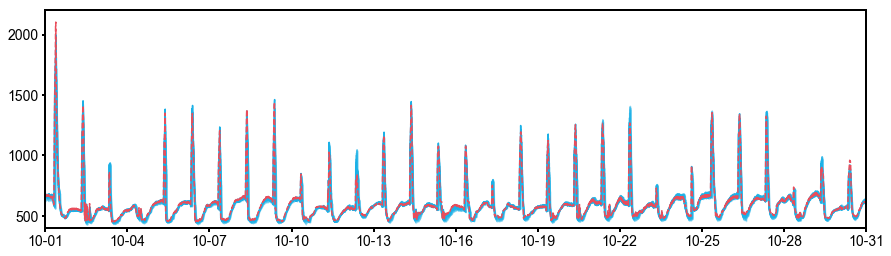

In [69]:
x_date = predictions.index
#LL = 9000

fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*1.6))
ax = plt.subplot()
#plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)


for j in range(0, predictions.shape[1]-1):
    a, = ax.plot(x_date, predictions.iloc[:,j], "-", markersize=MARKER_SIZE/10, c=cmap[4], alpha=1/(j/3+1))
#linear_sq1 = plt.plot(x_date, pred_squences.iloc[:,0], "-", c=cmap[3], alpha=1)
#linear_sq12 = plt.plot(x_date, pred_squences.iloc[:,11], "-", c=cmap[-1], alpha=1)
linear_label, = ax.plot(x_date, label_means, "--", markersize=MARKER_SIZE / 2, c=cmap[0])

#plt.legend(handles = [linear_label, a], labels = ["Measured", "Predicted"], bbox_to_anchor=(1, 1), frameon=False)

#months = MonthLocator(range(1, 13), bymonthday=3, interval=1)
#ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# mondays = WeekdayLocator(MONDAY)
# ax.xaxis.set_minor_locator(mondays)


#plt.xlabel("Time (mm-dd)")
#plt.ylabel("$CO_2\ concentration\ \mathit{({\mu}mol{\cdot}mol^{-1})}$")
ax.set_xbound([datetime.date(2017, 10, 1), datetime.date(2017, 10, 31)])
ax.set_ybound([400, 2200])
fig.tight_layout()
fig.savefig("./figures/Fig6c.png", dpi=600, transparent=True, format="png")
plt.show()

In [78]:
np.sqrt(mean_squared_error(pred_label.loc[datetime.date(2017,10,1):datetime.date(2017,10,31)].values.reshape(-1, 1),
                           pred_result.loc[datetime.date(2017,10,1):datetime.date(2017,10,31)].values.reshape(-1, 1)))

68.7205642746749

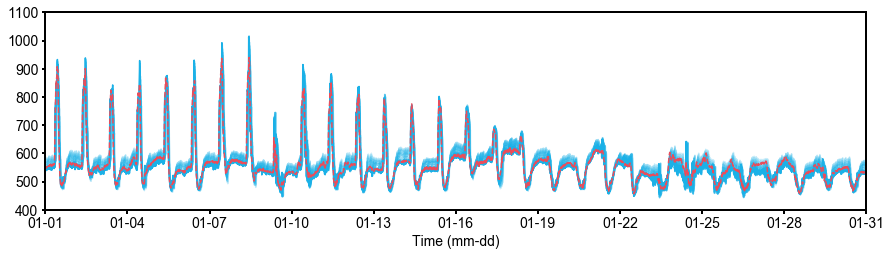

In [70]:
x_date = predictions.index
#LL = 9000

fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*1.6))
ax = plt.subplot()
#plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)


for j in range(0, predictions.shape[1]-1):
    a, = ax.plot(x_date, predictions.iloc[:,j], "-", markersize=MARKER_SIZE/10, c=cmap[4], alpha=1/(j/3+1))
#linear_sq1 = plt.plot(x_date, pred_squences.iloc[:,0], "-", c=cmap[3], alpha=1)
#linear_sq12 = plt.plot(x_date, pred_squences.iloc[:,11], "-", c=cmap[-1], alpha=1)
linear_label, = ax.plot(x_date, label_means, "--", markersize=MARKER_SIZE / 2, c=cmap[0])

#plt.legend(handles = [linear_label, a], labels = ["Measured", "Predicted"], bbox_to_anchor=(1, 1), frameon=False)

#months = MonthLocator(range(1, 13), bymonthday=3, interval=1)
#ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# mondays = WeekdayLocator(MONDAY)
# ax.xaxis.set_minor_locator(mondays)


plt.xlabel("Time (mm-dd)")
#plt.ylabel("$CO_2\ concentration\ \mathit{({\mu}mol{\cdot}mol^{-1})}$")
ax.set_xbound([datetime.date(2018, 1, 1), datetime.date(2018, 1, 31)])
ax.set_ybound([400, 1100])
fig.tight_layout()
fig.savefig("./figures/Fig6d.png", dpi=600, transparent=True, format="png")
plt.show()

In [79]:
np.sqrt(mean_squared_error(pred_label.loc[datetime.date(2018,1,1):datetime.date(2018,1,31)].values.reshape(-1, 1),
                           pred_result.loc[datetime.date(2018,1,1):datetime.date(2018,1,31)].values.reshape(-1, 1)))

24.56491650907065

In [ ]:
x_date = predictions.index
#LL = 9000

fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*1.5))
ax = plt.subplot()
#plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)

linear_label = ax.plot(x_date, label_means, "--", markersize=MARKER_SIZE / 2, c=cmap[0])
for j in range(0, predictions.shape[1]-1):
    ax.plot(x_date, predictions.iloc[:,j], "o", markersize=MARKER_SIZE/5, c=cmap[4], alpha=1/(j/3+1))
#linear_sq1 = plt.plot(x_date, pred_squences.iloc[:,0], "-", c=cmap[3], alpha=1)
#linear_sq12 = plt.plot(x_date, pred_squences.iloc[:,11], "-", c=cmap[-1], alpha=1)


#plt.legend(["Measured", "Predicted"], bbox_to_anchor=(1, 1), frameon=False)

months = MonthLocator(range(1, 13), bymonthday=3, interval=1)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

mondays = WeekdayLocator(MONDAY)
ax.xaxis.set_minor_locator(mondays)


plt.xlabel("Time (mm-dd)")
plt.ylabel("$CO_2\ concentration\ \mathit{({\mu}mol{\cdot}mol^{-1})}$")
ax.set_xbound([x_date[65000], x_date[65050]])
ax.set_ybound([200, 1200])
fig.tight_layout()
#fig.savefig("./figures/Fig6d.png", dpi=600, transparent=True, format="png")
plt.show()

In [ ]:
RMSEs = []
for i in range(predictions.shape[1]):
    temp = predictions.iloc[:,i].dropna()
    temp2 = label_means.reindex(pd.DatetimeIndex(temp.index))
    RMSE = np.sqrt(mean_squared_error(y_true=temp2, y_pred=temp))
    RMSEs.append(RMSE)
    print(RMSE)

In [ ]:
x_out = np.arange(1, OUTPUT_SIZE+1)
x_out_ = np.arange(OUTPUT_SIZE+5)
test_RMSE_mean = np.array([rmse_test]*x_out_.shape[0])
train_RMSE_mean = np.array([rmse_train]*x_out_.shape[0])

In [ ]:
x_date = predictions.index
#LL = 9000

fig = plt.figure(figsize=((8/2.54)*2, (6/2.54)*2))
ax = plt.subplot()
#plt.fill_between(x_date, pred_mins, pred_maxs, facecolor=cmap[-2], alpha=1)

test_mean_line = ax.plot(x_out_, test_RMSE_mean, "--", c=cmap[0])
train_mean_line = ax.plot(x_out_, train_RMSE_mean, "--", c=cmap[4])
rmse_line = ax.plot(x_out, RMSEs, "o-", markersize=MARKER_SIZE / 2, c='k')




ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))

plt.legend(["Test average", "Training average", "Each prediction"], loc=2, frameon=False)
plt.xlabel("Output sequence")
plt.ylabel("RMSE")
ax.set_xbound([0.5, 12.5])
ax.set_ybound([20, 90])
fig.tight_layout()
fig.savefig("./figures/Fig7.png", dpi=600, transparent=True, format="png")
plt.show()